In [1]:
import cv2
import os
import torch
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import imageio

import configparser
import argparse
from datetime import datetime

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
from torchvision.models import resnet34 as resnet
import torchvision.transforms as transforms
import albumentations as A

from functools import partial
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from timm.models.helpers import load_pretrained
from timm.models.registry import register_model
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [2]:
class SkinDataset(data.Dataset):
    """
    dataloader for skin lesion segmentation tasks
    """
    def __init__(self, image_root, gt_root):
        self.images = np.load(image_root)
        self.gts = np.load(gt_root)
        self.size = len(self.images)

        self.img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
        ])
        self.gt_transform = transforms.Compose([
            transforms.ToTensor()])
        
        self.transform = A.Compose(
            [
                A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0.15, rotate_limit=25, p=0.5, border_mode=0),
                A.ColorJitter(),
                A.HorizontalFlip(),
                A.VerticalFlip()
            ]
        )

    def __getitem__(self, index):
        
        image = self.images[index]
        gt = self.gts[index]
        gt = gt/255.0

        transformed = self.transform(image=image, mask=gt)
        image = self.img_transform(transformed['image'])
        gt = self.gt_transform(transformed['mask'])
        return image, gt

    def __len__(self):
        return self.size


def get_loader(image_root, gt_root, batchsize, shuffle=True, num_workers=4, pin_memory=True):

    dataset = SkinDataset(image_root, gt_root)
    data_loader = data.DataLoader(dataset=dataset,
                                  batch_size=batchsize,
                                  shuffle=shuffle,
                                  num_workers=num_workers,
                                  pin_memory=pin_memory)
    return data_loader


class test_dataset:
    def __init__(self, image_root, gt_root):
        self.images = np.load(image_root)
        self.gts = np.load(gt_root)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
            ])
        self.gt_transform = transforms.ToTensor()
        self.size = len(self.images)
        self.index = 0

    def load_data(self):
        image = self.images[self.index]
        image = self.transform(image).unsqueeze(0)
        gt = self.gts[self.index]
        gt = gt/255.0
        self.index += 1

        return image, gt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

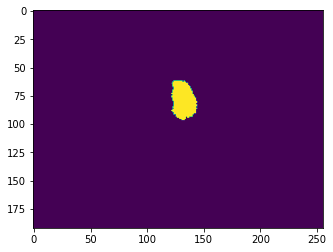

In [3]:
path = 'data/'
vis_path ='vis'
tt = SkinDataset(path+'data_train.npy', path+'mask_train.npy')

if vis_path is not None:
    os.makedirs(vis_path, exist_ok=True)

for i in range(50):
    img, gt = tt.__getitem__(i)
    img = torch.transpose(img, 0, 1)
    img = torch.transpose(img, 1, 2)
    img = img.numpy()
    gt = gt.numpy()

    plt.imshow(img)
    plt.savefig('vis/'+str(i)+".jpg")

    plt.imshow(gt[0])
    plt.savefig('vis/'+str(i)+'_gt.jpg')

## Visualize Predicted Segmentation Masks

In [11]:
in_path='inference/'

In [12]:
images=[]
gts=[]
preds=[]


def getFiles(path):
    for file in os.listdir(path):
        if file.endswith("_img.jpg"):
            images.append(os.path.join(path, file))
        if file.endswith("_gt.jpg"):
            gts.append(os.path.join(path, file))
        if file.endswith("_pred.jpg"):
            preds.append(os.path.join(path, file))

In [13]:
getFiles(in_path)

In [14]:
images=sorted(images)[2:6]
gts=sorted(gts)[2:6]
preds=sorted(preds)[2:6]

In [15]:
images

['inference/101_img.jpg',
 'inference/102_img.jpg',
 'inference/103_img.jpg',
 'inference/104_img.jpg']

In [16]:
gts

['inference/101_gt.jpg',
 'inference/102_gt.jpg',
 'inference/103_gt.jpg',
 'inference/104_gt.jpg']

In [17]:
preds

['inference/101_pred.jpg',
 'inference/102_pred.jpg',
 'inference/103_pred.jpg',
 'inference/104_pred.jpg']

In [20]:
plt.rcParams["figure.figsize"] = [12,8]
plt.rcParams["figure.autolayout"] = True

/tmp/ipykernel_891478/1950575845.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


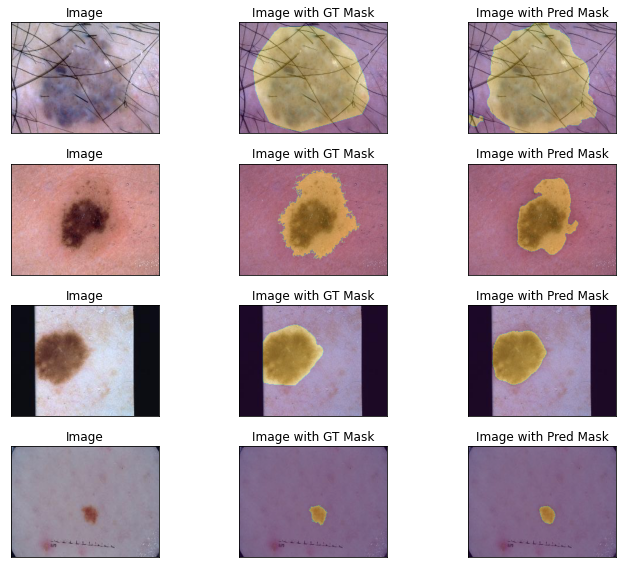

In [21]:
fig, ax = plt.subplots(4,3, sharex='all', sharey='all')
for i,(img,gt,pred) in enumerate(list(zip(images,gts,preds))):

    img = plt.imread(img)
    gt  = plt.imread(gt)
    pred= plt.imread(pred)

    ax[i,0].imshow(img)
    ax[i,0].set_title('Image')
    ax[i,1].imshow(img)
    ax[i,1].imshow(gt, alpha=0.3)
    ax[i,1].set_title('Image with GT Mask')
    ax[i,2].imshow(img)
    ax[i,2].imshow(pred, alpha=0.3)
    ax[i,2].set_title('Image with Pred Mask')

    plt.xticks([])
    plt.yticks([])
fig.show()

fig.savefig('overlapped.jpg')


In [22]:
# SR : Segmentation Result
# GT : Ground Truth

def get_accuracy(SR,GT,threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)
    corr = torch.sum(SR==GT)
    tensor_size = SR.size(0)*SR.size(1)*SR.size(2)*SR.size(3)
    acc = float(corr)/float(tensor_size)

    return acc

def get_sensitivity(SR,GT,threshold=0.5):
    # Sensitivity == Recall
    SR = SR > threshold
    GT = GT == torch.max(GT)

    # TP : True Positive
    # FN : False Negative
    TP = ((SR==1)+(GT==1))==2
    FN = ((SR==0)+(GT==1))==2

    SE = float(torch.sum(TP))/(float(torch.sum(TP+FN)) + 1e-6)     
    
    return SE

def get_specificity(SR,GT,threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)

    # TN : True Negative
    # FP : False Positive
    TN = ((SR==0)+(GT==0))==2
    FP = ((SR==1)+(GT==0))==2

    SP = float(torch.sum(TN))/(float(torch.sum(TN+FP)) + 1e-6)
    
    return SP

def get_precision(SR,GT,threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)

    # TP : True Positive
    # FP : False Positive
    TP = ((SR==1)+(GT==1))==2
    FP = ((SR==1)+(GT==0))==2

    PC = float(torch.sum(TP))/(float(torch.sum(TP+FP)) + 1e-6)

    return PC

def get_F1(SR,GT,threshold=0.5):
    # Sensitivity == Recall
    SE = get_sensitivity(SR,GT,threshold=threshold)
    PC = get_precision(SR,GT,threshold=threshold)

    F1 = 2*SE*PC/(SE+PC + 1e-6)

    return F1

def get_JS(SR,GT,threshold=0.5):
    # JS : Jaccard similarity
    SR = SR > threshold
    GT = GT == torch.max(GT)
    
    Inter = torch.sum((SR+GT)==2)
    Union = torch.sum((SR+GT)>=1)
    
    JS = float(Inter)/(float(Union) + 1e-6)
    
    return JS

def get_DC(SR,GT,threshold=0.5):
    # DC : Dice Coefficient
    SR = SR > threshold
    GT = GT == torch.max(GT)

    Inter = torch.sum((SR+GT)==2)
    DC = float(2*Inter)/(float(torch.sum(SR)+torch.sum(GT)) + 1e-6)

    return DC